ValueError: too many values to unpack (expected 2)

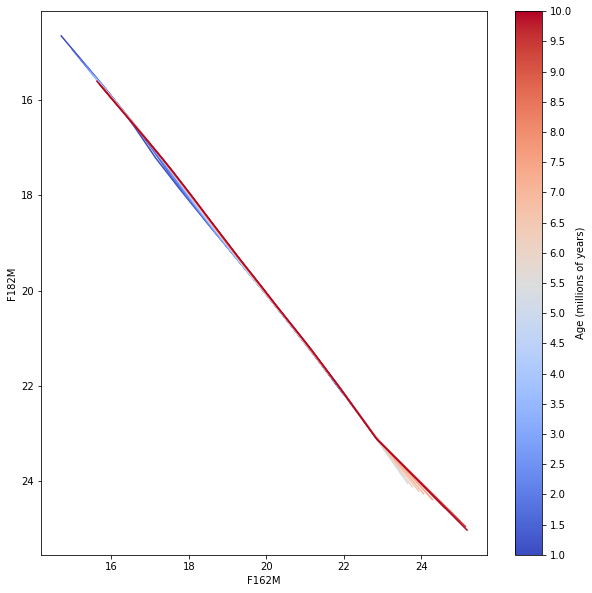

In [7]:
# Import necessary packages
import numpy as np
import pylab as py
import matplotlib.pyplot as plt
from spisea import synthetic, evolution, atmospheres, reddening, ifmr
from spisea.imf import imf, multiplicity
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import csv

# Estimation variables
star_index = 0      # Set which star in the CSV to analyze
num_top_predictions = 10     # Control how many top predictions to plot

# Define isochrone parameters
AKs = 0
dist = 4500
evo_model = evolution.Baraffe15()
atm_func = atmospheres.get_merged_atmosphere
red_law = reddening.RedLawHosek18b()
filt_list = ['jwst,F162M', 'jwst,F182M', 'jwst,F200W', 'jwst,F356W', 'jwst,F405N']
filters = ['m_jwst_F162M', 'm_jwst_F182M', 'm_jwst_F200W', 'm_jwst_F356W', 'm_jwst_F405N']
iso_dir = 'isochrones/'
metallicity = 0

# Generate isochrone grid
level_ages = np.linspace(1, 10, 19) * 1e6
log_age_arr = np.log10(level_ages)
instances = np.array([
    synthetic.IsochronePhot(log_age, AKs, dist, metallicity=metallicity,
                            evo_model=evo_model, atm_func=atm_func,
                            red_law=red_law, filters=filt_list,
                            iso_dir=iso_dir)
    for log_age in log_age_arr
])

# Chi-square minimization function
def chi_square_reverse_model(iso_grid, sample_mags):
    results = []
    for i, iso in enumerate(iso_grid):
        for star in iso.points:
            chi_square = sum(((sample_mags[k] - star[filters[k]]) ** 2) / star[filters[k]] for k in range(len(sample_mags)))
            results.append([chi_square, star['mass'], 10 ** log_age_arr[i]])
    
    return sorted(results, key=lambda x: x[0])

# Load sample magnitudes, skipping the header row
sample_mags = []
with open('../s284-no-errors.csv', mode='r') as file:
    csvFile = csv.reader(file)
    next(csvFile)  # Skip header row
    for lines in csvFile:
        sample_mags.append([float(x) for x in lines[1:]])  # Convert each entry to float
        
# Run chi-square minimization and store top results
sorted_results = chi_square_reverse_model(instances, sample_mags[0])
top_results = sorted_results[:num_top_predictions]  # For example, we take the top 10 best matches

# Generate plot
fig, ax = plt.subplots(figsize=(10, 10))
cmap = plt.get_cmap('coolwarm')

# Plot all isochrones with colors based on age
for i, instance in enumerate(instances):
    color = cmap(i / (len(instances) - 1))  # Assign color based on index and colormap
    ax.plot(instance.points[filters[0]], instance.points[filters[1]], color=color)

ax.set_xlabel('F162M')
ax.set_ylabel('F182M')
ax.invert_yaxis()

# Create colorbar legend
norm = Normalize(vmin=min(level_ages), vmax=max(level_ages))
sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Age (millions of years)')
cbar.set_ticks(level_ages)
cbar.set_ticklabels([f'{age/1e6:.1f}' for age in level_ages])

# Plot each estimated star's position in red on the diagram
for j, (chi_square, mass, age) in top_results:
    # Find the closest age in level_ages to the estimated age
    closest_age_idx = np.argmin(abs(level_ages - age))
    iso_instance = instances[closest_age_idx]  # Access the isochrone instance

    # Find the star in the isochrone closest to the estimated mass
    mass_idx = np.argmin(abs(iso_instance.points['mass'] - mass))
    
    # Plot the star's position on the color-magnitude diagram
    ax.plot(iso_instance.points[mass_idx][filters[0]], iso_instance.points[mass_idx][filters[1]], 'o', color='red')

    # Plot each estimated star point with color gradient and labels
    ax.plot(
        iso_instance.points[mass_idx][filters[0]],
        iso_instance.points[mass_idx][filters[1]],
        'o', color=cmap(j / num_top_predictions),
        label=f"Est. Mass: {mass:.2f}, Age: {age/1e6:.1f} Myr"
    )

# Plot reference star
ax.plot(sample_mags[star_index][0], sample_mags[star_index][1], '*', color='purple', 
        markersize=10, label="Reference Star")
    
ax.legend()
    
plt.show()

In [ ]:
# import packages
import numpy as np
import pylab as py
import matplotlib.pyplot as plt
import math

# import spisea packages
from spisea import synthetic, evolution, atmospheres, reddening, ifmr
from spisea.imf import imf, multiplicity

# colormap imports for plot generation
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# csv parser for reading S284 data
import csv

# Isochrone parameters

In [ ]:
# define isochrone parameters
AKs = 0
dist = 4500
evo_model = evolution.Baraffe15()
atm_func = atmospheres.get_merged_atmosphere
red_law = reddening.RedLawHosek18b()
filt_list = ['jwst,F162M', 'jwst,F182M', 'jwst,F200W', 'jwst,F356W', 'jwst,F405N']
filters = ['m_jwst_F162M', 'm_jwst_F182M', 'm_jwst_F200W', 'm_jwst_F356W', 'm_jwst_F405N']
iso_dir = 'isochrones/'
metallicity = 0

In [ ]:
# define log age array for isochrone grid
level_ages = np.linspace(1, 10, 19) * 1e6
log_age_arr = np.log10(level_ages)

# Generate isochrone grid

In [ ]:
instances = np.array([
    synthetic.IsochronePhot(log_age, AKs, dist, metallicity=metallicity,
                            evo_model=evo_model, atm_func=atm_func,
                            red_law=red_law, filters=filt_list,
                                iso_dir=iso_dir)
    for log_age in log_age_arr
])
        
print("isochrone generation done")

# Function for calculating chi-square value based on photometric magnitudes

In [ ]:
def chi_square_reverse_model(iso_grid, sample_mags):
    results = []
    
    for i in range(len(iso_grid)):
        for j in range(len(iso_grid[i].points)):
            arr = []
            chi_square = 0
            for k in range(len(sample_mags)):
                mag_obs = sample_mags[k]
                mag_exp = iso_grid[i].points[j][filters[k]]
                chi_square = chi_square + (((mag_obs - mag_exp) ** 2) / mag_exp)

            arr.append(chi_square)
            arr.append(iso_grid[i].points[j]['mass'])
            arr.append(10 ** log_age_arr[i])
            
            results.append(arr)
    
    sorted_results = sorted(results, key=sort_by_chi_square)
    
    report(sorted_results[:10])
    
def sort_by_chi_square(sub_list):
    return sub_list[0]

def report(output_arr):
    for i in range(len(output_arr)):
        print("Chi-square: " + str(output_arr[i][0]))
        print("Mass (Msun): " + str(output_arr[i][1]))
        print("Age (Myr): " + str(output_arr[i][2]))
        print()

# Define S284 sample magnitudes and run function

In [ ]:
sample_mags = []

import csv
with open('../s284-no-errors.csv', mode ='r')as file:
  csvFile = csv.reader(file)
  for lines in csvFile:
        sample_mags.append(lines)

sample_mags.pop(0)

In [ ]:
# convert value array to numbers
for i in range(len(sample_mags)):
    for j in range(len(sample_mags[i])):
        sample_mags[i][j] = float(sample_mags[i][j])
print(sample_mags)

In [ ]:
for i in range(len(sample_mags)):
    chi_square_reverse_model(instances, sample_mags[i])
    print("==========================================")

In [ ]:
# Plot of estimated points from first trial run for first star
cmap = plt.get_cmap('coolwarm')

py.figure(figsize=(10, 10))

for i in range(len(log_age_arr)):
    color = cmap(i / (len(log_age_arr) - 1))  # Assign color based on index and colormap
    py.plot(instances[i].points[filters[0]] - instances[i].points[filters[1]], 
        instances[i].points[filters[1]], color=color, label='')

py.xlabel('F162M - F182M')
py.ylabel('F182M')
py.gca().invert_yaxis()

# Create colorbar legend
norm = Normalize(vmin=min(level_ages), vmax=max(level_ages))
sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Age (millions of years)')
cbar.set_ticks(level_ages)
cbar.set_ticklabels([f'{age/1e6:.1f}' for age in level_ages])

py.plot(sample_mags[0][0] - sample_mags[0][1], sample_mags[0][1], '*')

# 1ST ESTIMATE
idx = np.where( abs(instances[0].points['mass'] - 0.3) == min(abs(instances[0].points['mass'] - 0.3)) )[0]
py.plot(instances[0].points[idx[0]]['m_jwst_F162M'] - instances[0].points[idx[0]]['m_jwst_F182M'], 
        instances[0].points[idx[0]]['m_jwst_F182M'], 'o', color='red')
# 2ND ESTIMATE
idx = np.where( abs(instances[0].points['mass'] - 0.2) == min(abs(instances[0].points['mass'] - 0.2)) )[0]
py.plot(instances[0].points[idx[0]]['m_jwst_F162M'] - instances[0].points[idx[0]]['m_jwst_F182M'], 
        instances[0].points[idx[0]]['m_jwst_F182M'], 'o', color='red')
# 3RD ESTIMATE
idx = np.where( abs(instances[1].points['mass'] - 0.4) == min(abs(instances[1].points['mass'] - 0.4)) )[0]
py.plot(instances[1].points[idx[0]]['m_jwst_F162M'] - instances[1].points[idx[0]]['m_jwst_F182M'], 
        instances[1].points[idx[0]]['m_jwst_F182M'], 'o', color='red')
# 4TH ESTIMATE
idx = np.where( abs(instances[0].points['mass'] - 0.4) == min(abs(instances[0].points['mass'] - 0.4)) )[0]
py.plot(instances[0].points[idx[0]]['m_jwst_F162M'] - instances[0].points[idx[0]]['m_jwst_F182M'], 
        instances[0].points[idx[0]]['m_jwst_F182M'], 'o', color='red')
# 5TH ESTIMATE
idx = np.where( abs(instances[0].points['mass'] - 0.17) == min(abs(instances[0].points['mass'] - 0.17)) )[0]
py.plot(instances[0].points[idx[0]]['m_jwst_F162M'] - instances[0].points[idx[0]]['m_jwst_F182M'], 
        instances[0].points[idx[0]]['m_jwst_F182M'], 'o', color='red')
# 6TH ESTIMATE
idx = np.where( abs(instances[1].points['mass'] - 0.3) == min(abs(instances[1].points['mass'] - 0.3)) )[0]
py.plot(instances[1].points[idx[0]]['m_jwst_F162M'] - instances[1].points[idx[0]]['m_jwst_F182M'], 
        instances[1].points[idx[0]]['m_jwst_F182M'], 'o', color='red')
# 7TH ESTIMATE
idx = np.where( abs(instances[0].points['mass'] - 0.5) == min(abs(instances[0].points['mass'] - 0.5)) )[0]
py.plot(instances[2].points[idx[0]]['m_jwst_F162M'] - instances[2].points[idx[0]]['m_jwst_F182M'], 
        instances[2].points[idx[0]]['m_jwst_F182M'], 'o', color='red')
# 8TH ESTIMATE
idx = np.where( abs(instances[0].points['mass'] - 0.5) == min(abs(instances[0].points['mass'] - 0.5)) )[0]
py.plot(instances[1].points[idx[0]]['m_jwst_F162M'] - instances[1].points[idx[0]]['m_jwst_F182M'], 
        instances[1].points[idx[0]]['m_jwst_F182M'], 'o', color='red')
# 9TH ESTIMATE
idx = np.where( abs(instances[2].points['mass'] - 0.4) == min(abs(instances[2].points['mass'] - 0.4)) )[0]
py.plot(instances[2].points[idx[0]]['m_jwst_F162M'] - instances[2].points[idx[0]]['m_jwst_F182M'], 
        instances[2].points[idx[0]]['m_jwst_F182M'], 'o', color='red')
# 10TH ESTIMATE
idx = np.where( abs(instances[3].points['mass'] - 0.5) == min(abs(instances[3].points['mass'] - 0.5)) )[0]
py.plot(instances[3].points[idx[0]]['m_jwst_F162M'] - instances[3].points[idx[0]]['m_jwst_F182M'], 
        instances[3].points[idx[0]]['m_jwst_F182M'], 'o', color='red')

In [ ]:
# Plot of estimated points from first trial run for first star
cmap = plt.get_cmap('coolwarm')

py.figure(figsize=(10, 10))

for i in range(len(log_age_arr)):
    color = cmap(i / (len(log_age_arr) - 1))  # Assign color based on index and colormap
    py.plot(instances[i].points[filters[0]], instances[i].points[filters[1]], color=color, label='')

py.xlabel('F162M')
py.ylabel('F182M')
py.gca().invert_yaxis()

# Create colorbar legend
norm = Normalize(vmin=min(level_ages), vmax=max(level_ages))
sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Age (millions of years)')
cbar.set_ticks(level_ages)
cbar.set_ticklabels([f'{age/1e6:.1f}' for age in level_ages])

py.plot(sample_mags[0][0] - sample_mags[0][1], sample_mags[0][1], '*')


idx = np.where( abs(instances[0].points['mass'] - 0.3) == min(abs(instances[0].points['mass'] - 0.3)) )[0]
py.plot(instances[0].points[idx[0]]['m_jwst_F162M'], instances[0].points[idx[0]]['m_jwst_F182M'], 'o', color='red')

idx = np.where( abs(instances[0].points['mass'] - 0.2) == min(abs(instances[0].points['mass'] - 0.2)) )[0]
py.plot(instances[0].points[idx[0]]['m_jwst_F162M'], instances[0].points[idx[0]]['m_jwst_F182M'], 'o', color='red')

idx = np.where( abs(instances[1].points['mass'] - 0.4) == min(abs(instances[1].points['mass'] - 0.4)) )[0]
py.plot(instances[1].points[idx[0]]['m_jwst_F162M'], instances[1].points[idx[0]]['m_jwst_F182M'], 'o', color='red')

idx = np.where( abs(instances[0].points['mass'] - 0.4) == min(abs(instances[0].points['mass'] - 0.4)) )[0]
py.plot(instances[0].points[idx[0]]['m_jwst_F162M'], instances[0].points[idx[0]]['m_jwst_F182M'], 'o', color='red')

idx = np.where( abs(instances[0].points['mass'] - 0.17) == min(abs(instances[0].points['mass'] - 0.17)) )[0]
py.plot(instances[0].points[idx[0]]['m_jwst_F162M'], instances[0].points[idx[0]]['m_jwst_F182M'], 'o', color='red')

idx = np.where( abs(instances[1].points['mass'] - 0.3) == min(abs(instances[1].points['mass'] - 0.3)) )[0]
py.plot(instances[1].points[idx[0]]['m_jwst_F162M'], instances[1].points[idx[0]]['m_jwst_F182M'], 'o', color='red')

idx = np.where( abs(instances[0].points['mass'] - 0.5) == min(abs(instances[0].points['mass'] - 0.5)) )[0]
py.plot(instances[2].points[idx[0]]['m_jwst_F162M'], instances[2].points[idx[0]]['m_jwst_F182M'], 'o', color='red')

idx = np.where( abs(instances[0].points['mass'] - 0.5) == min(abs(instances[0].points['mass'] - 0.5)) )[0]
py.plot(instances[1].points[idx[0]]['m_jwst_F162M'], instances[1].points[idx[0]]['m_jwst_F182M'], 'o', color='red')

idx = np.where( abs(instances[2].points['mass'] - 0.4) == min(abs(instances[2].points['mass'] - 0.4)) )[0]
py.plot(instances[2].points[idx[0]]['m_jwst_F162M'], instances[2].points[idx[0]]['m_jwst_F182M'], 'o', color='red')

idx = np.where( abs(instances[3].points['mass'] - 0.5) == min(abs(instances[3].points['mass'] - 0.5)) )[0]
py.plot(instances[3].points[idx[0]]['m_jwst_F162M'], instances[3].points[idx[0]]['m_jwst_F182M'], 'o', color='red')